# Import Relevant Librys

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import torch.nn.init as init
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

# Load Cuda device if exist

In [2]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Load and transform MNIST Data set

In [3]:
down_flag = True # (Optional) usually false

# # Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor()])
# Download and load the training data
train_data = datasets.FashionMNIST('F_MNIST_data', download=down_flag, train=True, transform=transform)
# Download and load the test data
test_data = datasets.FashionMNIST('F_MNIST_data', download=down_flag, train=False, transform=transform)

train_data, test_data

100%|██████████| 26421880/26421880 [00:01<00:00, 14905081.43it/s]


Extracting F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to F_MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 266923.00it/s]


Extracting F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to F_MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5007701.53it/s]


Extracting F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to F_MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 20217487.82it/s]

Extracting F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to F_MNIST_data/FashionMNIST/raw



(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: F_MNIST_data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
            ),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: F_MNIST_data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
            ))

# Pre-Processing data (Normalization)

In [4]:
# Calculate mean and std
imgs = torch.stack([img for img, _ in train_data], dim=0)

mean = imgs.view(1, -1).mean(dim=1)    # or imgs.mean()
std = imgs.view(1, -1).std(dim=1)     # or imgs.std()
mean, std

(tensor([0.2860]), tensor([0.3530]))

In [5]:
down_flag = False # (Optional) usually false

# # Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=mean, std=std)])
# Download and load the training data
train_data = datasets.FashionMNIST('F_MNIST_data', download=down_flag, train=True, transform=transform)
# Download and load the test data
test_data = datasets.FashionMNIST('F_MNIST_data', download=down_flag, train=False, transform=transform)

train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: F_MNIST_data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=tensor([0.2860]), std=tensor([0.3530]))
            ),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: F_MNIST_data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=tensor([0.2860]), std=tensor([0.3530]))
            ))

# Iterating and Visualizing the Dataset

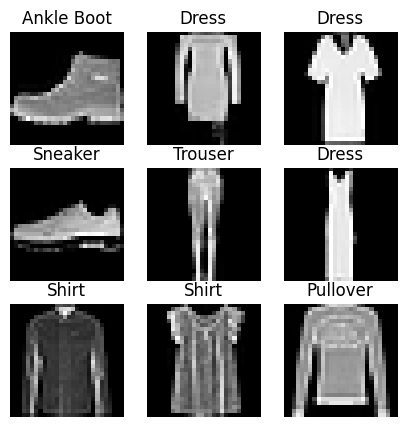

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

labels_map={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

figure = plt.figure(figsize = (5,5))
cols, rows = 3, 3

for i in range (1, cols*rows + 1):
    sample_idx = torch.randint(len(train_data), size = (1,)).item()
    image, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()

Split to train and valid in addition prepare dataloader for training

In [7]:
# Hyper-parameters
batch_size = 64
valid_size = 0.2

# Data Loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

# Build LeNet5

In [14]:
class LeNet5(nn.Module):
    def __init__(self, useDrop=False, useBatchNorm=False):
        super(LeNet5, self).__init__()
        # Define Configuration Param
        self.useDrop = useDrop
        self.useBatchNorm = useBatchNorm
        # Define NN elements
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.Linear1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.linear2 = nn.Linear(in_features=120, out_features=84)
        self.linear3 = nn.Linear(in_features=84, out_features=10)


        if self.useBatchNorm:
            self.bn1 = nn.BatchNorm2d(6)
            self.bn2 = nn.BatchNorm2d(16)
            self.bn3 = nn.BatchNorm1d(120)
            self.bn4 = nn.BatchNorm1d(84)

        if self.useDrop:
            self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        # Layer 1
        x = self.conv1(x)
        if self.useBatchNorm:
            x = self.bn1(x)
        x = self.pool(F.relu(x))
        # Layer 2
        x = self.conv2(x)
        if self.useBatchNorm:
            x = self.bn2(x)
        x = self.pool(F.relu(x))
        # Layer 3
        x = x.view(x.size(0), -1) # Flatten the input tensor
        x = self.Linear1(x)
        if self.useBatchNorm:
            x = self.bn3(x)
        x = F.relu(x)

        # Layer 4
        if self.useDrop:
            x = self.dropout(x)
        x = self.linear2(x)
        if self.useBatchNorm:
            x = self.bn4(x)
        x = F.relu(x)
        # Layer 5 output
        x = self.linear3(x)

        return x


# Train Loop

In [15]:
def TrainLoop(train_loader,
              valid_loader,
              useDrop=False,
              useBatchNorm=False,
              use_Weight_decay=False,
              num_epochs=10,
              lr_init=0.001,
              PATH='./LeNet5.pth'):

    # Initalize gpu
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Define the model and move it to the device
    model = LeNet5(useDrop=False, useBatchNorm=False).to(device)
    print(model)

    # Define optimizer and criterion
    if use_Weight_decay:
        l2_reg = 0.0001
    else:
        l2_reg = 0.0
    optimizer = optim.Adam(model.parameters(), lr=lr_init, weight_decay=l2_reg)
    criterion = nn.CrossEntropyLoss()

    # Lists to store losses and accuracies
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct = run_epoch(model, train_loader, criterion, optimizer, device, is_training=True)
        train_acc = train_correct / len(train_loader.dataset)

        # Validation loop
        model.eval()
        val_loss, val_correct = run_epoch(model, valid_loader, criterion, optimizer, device, is_training=False)
        val_acc = val_correct / len(valid_loader.dataset)

        # Print the losses and accuracies for the epoch
        print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, \n Val Loss: {:.4f}, Val Acc: {:.4f}'
              .format(epoch+1, num_epochs, train_loss, train_acc, val_loss, val_acc))

        # Store the losses and accuracies for plotting
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

    # Finally, save weights
    torch.save(model.state_dict(), PATH)

    # Return results for plotting
    return train_losses, val_losses, train_accs, val_accs


def run_epoch(model, dataloader, criterion, optimizer, device, is_training=True):
    epoch_loss = 0.0
    correct_preds = 0

    with torch.set_grad_enabled(is_training):
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)

            # Zero grad
            optimizer.zero_grad()

            # Forward-prop
            output = model(data)

            # Calc loss
            loss = criterion(output, target)
            epoch_loss += loss.item()

            if is_training:
                # Backward pass and update the parameters
                loss.backward()
                optimizer.step()

            # Calculate the number of correct predictions
            _, predicted = torch.max(output.data, 1)
            correct_preds += (predicted == target).sum().item()

    # Calculate the average loss for the epoch
    epoch_loss /= len(dataloader)

    return epoch_loss, correct_preds

Run simple Net =  without any batchnorm or dropout

In [16]:
train_losses_simple, val_losses_simple, train_accs_simple, val_accs_simple = TrainLoop(train_loader,
                                                                                        valid_loader,
                                                                                        useDrop=False, useBatchNorm=False, use_Weight_decay=False,
                                                                                        num_epochs=30,
                                                                                        lr_init=0.01,
                                                                                        PATH = './LeNet5(simple).pth')

LeNet5(
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (Linear1): Linear(in_features=400, out_features=120, bias=True)
  (linear2): Linear(in_features=120, out_features=84, bias=True)
  (linear3): Linear(in_features=84, out_features=10, bias=True)
)
Epoch [1/30], Train Loss: 0.5047, Train Acc: 0.8110, 
 Val Loss: 0.3865, Val Acc: 0.8617
Epoch [2/30], Train Loss: 0.3615, Train Acc: 0.8666, 
 Val Loss: 0.4086, Val Acc: 0.8525
Epoch [3/30], Train Loss: 0.3409, Train Acc: 0.8759, 
 Val Loss: 0.3868, Val Acc: 0.8623
Epoch [4/30], Train Loss: 0.3193, Train Acc: 0.8841, 
 Val Loss: 0.3667, Val Acc: 0.8746
Epoch [5/30], Train Loss: 0.3131, Train Acc: 0.8867, 
 Val Loss: 0.3392, Val Acc: 0.8789
Epoch [6/30], Train Loss: 0.3027, Train Acc: 0.8905, 
 Val Loss: 0.3583, Val Acc: 0.8754
Epoch [7/30], Train Loss: 0.2983, Train Acc: 0.8927, 
 Val Loss: 0.384

Run NN with BatchNorm

In [17]:
train_losses_bn, val_losses_bn, train_accs_bn, val_accs_bn = TrainLoop(train_loader,
                                                                        valid_loader,
                                                                        useDrop=False, useBatchNorm=True, use_Weight_decay=False,
                                                                        num_epochs=30,
                                                                        lr_init=0.01,
                                                                        PATH = './LeNet5(BN).pth')

LeNet5(
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (Linear1): Linear(in_features=400, out_features=120, bias=True)
  (linear2): Linear(in_features=120, out_features=84, bias=True)
  (linear3): Linear(in_features=84, out_features=10, bias=True)
)
Epoch [1/30], Train Loss: 0.5257, Train Acc: 0.8057, 
 Val Loss: 0.4390, Val Acc: 0.8426
Epoch [2/30], Train Loss: 0.3708, Train Acc: 0.8639, 
 Val Loss: 0.3924, Val Acc: 0.8655
Epoch [3/30], Train Loss: 0.3388, Train Acc: 0.8770, 
 Val Loss: 0.3656, Val Acc: 0.8643
Epoch [4/30], Train Loss: 0.3243, Train Acc: 0.8821, 
 Val Loss: 0.3625, Val Acc: 0.8748
Epoch [5/30], Train Loss: 0.3116, Train Acc: 0.8869, 
 Val Loss: 0.3442, Val Acc: 0.8779
Epoch [6/30], Train Loss: 0.3011, Train Acc: 0.8904, 
 Val Loss: 0.3641, Val Acc: 0.8694
Epoch [7/30], Train Loss: 0.3048, Train Acc: 0.8892, 
 Val Loss: 0.395

Use weight decay

In [18]:
train_losses_l2, val_losses_l2, train_accs_l2, val_accs_l2 = TrainLoop(train_loader,
                                                                        valid_loader,
                                                                        useDrop=False, useBatchNorm=False, use_Weight_decay=True,
                                                                        num_epochs=30,
                                                                        lr_init=0.01,
                                                                        PATH = './LeNet5(Weight_decay).pth')

LeNet5(
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (Linear1): Linear(in_features=400, out_features=120, bias=True)
  (linear2): Linear(in_features=120, out_features=84, bias=True)
  (linear3): Linear(in_features=84, out_features=10, bias=True)
)
Epoch [1/30], Train Loss: 0.5185, Train Acc: 0.8072, 
 Val Loss: 0.4113, Val Acc: 0.8495
Epoch [2/30], Train Loss: 0.3786, Train Acc: 0.8613, 
 Val Loss: 0.3782, Val Acc: 0.8625
Epoch [3/30], Train Loss: 0.3459, Train Acc: 0.8732, 
 Val Loss: 0.3837, Val Acc: 0.8638
Epoch [4/30], Train Loss: 0.3329, Train Acc: 0.8774, 
 Val Loss: 0.3488, Val Acc: 0.8737
Epoch [5/30], Train Loss: 0.3163, Train Acc: 0.8830, 
 Val Loss: 0.3400, Val Acc: 0.8759
Epoch [6/30], Train Loss: 0.3107, Train Acc: 0.8840, 
 Val Loss: 0.3214, Val Acc: 0.8801
Epoch [7/30], Train Loss: 0.3079, Train Acc: 0.8866, 
 Val Loss: 0.354

Use Drop Out

In [19]:
train_losses_drop, val_losses_drop, train_accs_drop, val_accs_drop = TrainLoop(train_loader,
                                                                        valid_loader,
                                                                        useDrop=True, useBatchNorm=False, use_Weight_decay=False,
                                                                        num_epochs=30,
                                                                        lr_init=0.01,
                                                                        PATH = './LeNet5(Drop_Out).pth')

LeNet5(
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (Linear1): Linear(in_features=400, out_features=120, bias=True)
  (linear2): Linear(in_features=120, out_features=84, bias=True)
  (linear3): Linear(in_features=84, out_features=10, bias=True)
)
Epoch [1/30], Train Loss: 0.5074, Train Acc: 0.8132, 
 Val Loss: 0.3734, Val Acc: 0.8648
Epoch [2/30], Train Loss: 0.3606, Train Acc: 0.8695, 
 Val Loss: 0.3591, Val Acc: 0.8703
Epoch [3/30], Train Loss: 0.3312, Train Acc: 0.8793, 
 Val Loss: 0.3787, Val Acc: 0.8634
Epoch [4/30], Train Loss: 0.3260, Train Acc: 0.8813, 
 Val Loss: 0.3547, Val Acc: 0.8774
Epoch [5/30], Train Loss: 0.3059, Train Acc: 0.8891, 
 Val Loss: 0.3458, Val Acc: 0.8786
Epoch [6/30], Train Loss: 0.3037, Train Acc: 0.8900, 
 Val Loss: 0.3314, Val Acc: 0.8811
Epoch [7/30], Train Loss: 0.2926, Train Acc: 0.8925, 
 Val Loss: 0.330

# Plot Results

In [20]:
def plot_results(num_epochs=10,
                 Name="",
                 train_loss=[], train_acc=[],
                 valid_loss=[], valid_acc=[]):
    epoch_list = [i for i in range(1, num_epochs+1)]

    plt.figure(1)
    plt.plot(epoch_list, train_loss, label='train_losses'), plt.plot(epoch_list, valid_loss, label='test_losses'), plt.legend()
    plt.xlabel('epoch'), plt.ylabel('loss'), plt.grid(True), plt.title(f"Loss Train plot {Name}")
    plt.figure(2)
    plt.plot(epoch_list, train_acc, label='train_acc'), plt.plot(epoch_list, valid_acc, label='test_acc'), plt.legend()
    plt.xlabel('epoch'), plt.ylabel('Acc'), plt.grid(True), plt.title(f"Train accuracy plot {Name}")
    plt.show()


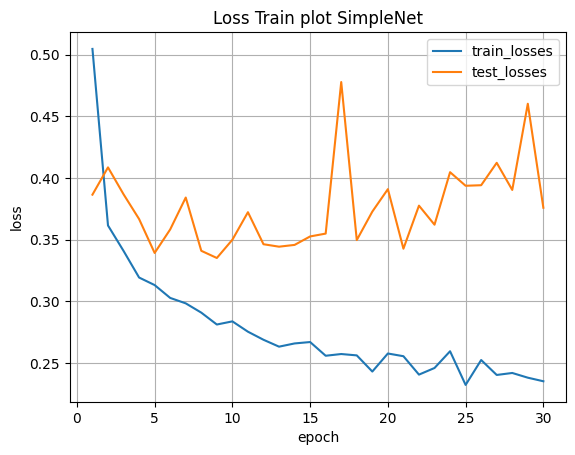

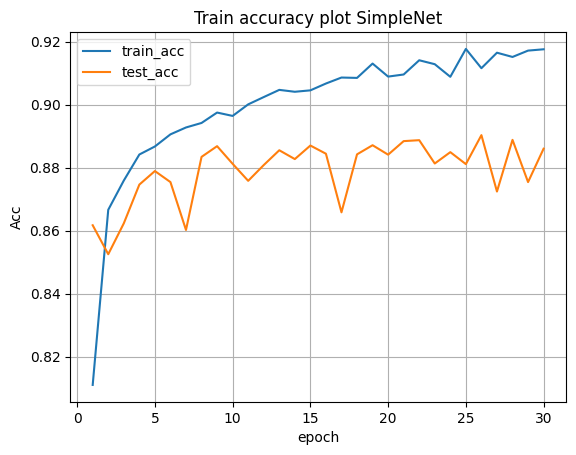

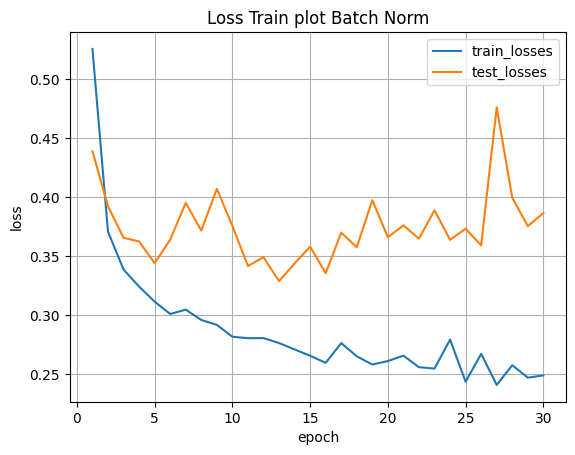

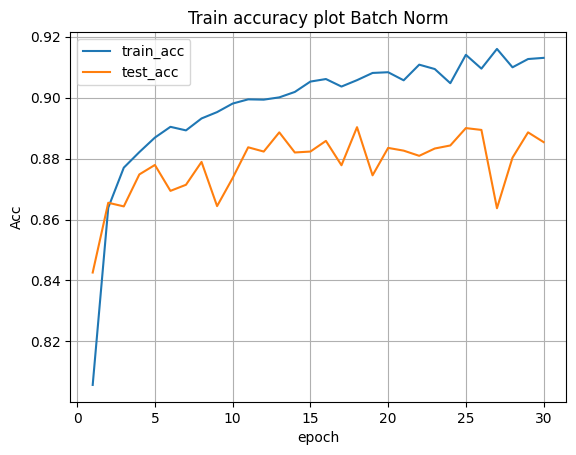

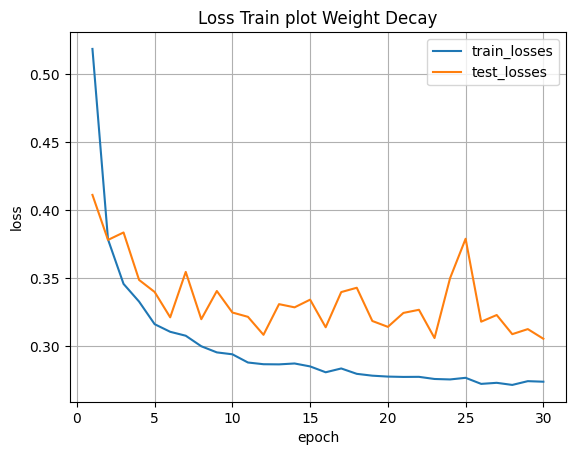

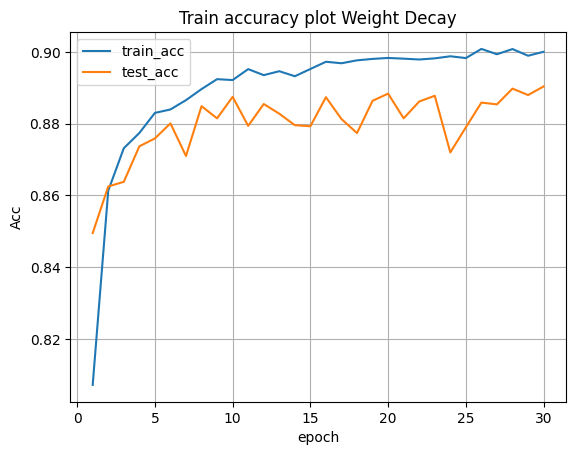

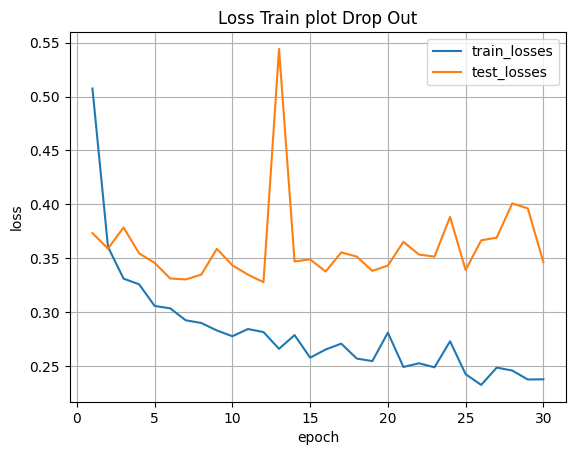

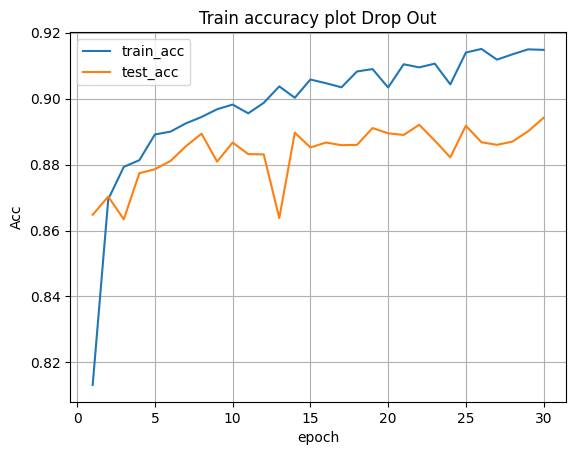

In [21]:
plot_results(30, "SimpleNet", train_losses_simple, train_accs_simple,
                 val_losses_simple, val_accs_simple)

plot_results(30, "Batch Norm", train_losses_bn, train_accs_bn,
                 val_losses_bn, val_accs_bn)

plot_results(30, "Weight Decay", train_losses_l2, train_accs_l2,
                 val_losses_l2, val_accs_l2)

plot_results(30, "Drop Out", train_losses_drop, train_accs_drop,
                 val_losses_drop, val_accs_drop)

# Table Final Results

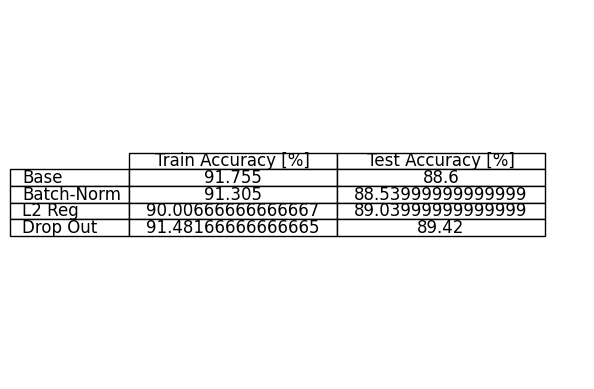

In [22]:

# define the column titles
columns = ('Train Accuracy [%]', 'Test Accuracy [%]')

# extract the row labels and data from the dictionary
rows = ["Base", "Batch-Norm", "L2 Reg", "Drop Out"]
data = [[train_accs_simple[-1]*100, val_accs_simple[-1]*100],
        [train_accs_bn[-1]*100, val_accs_bn[-1]*100],
        [train_accs_l2[-1]*100, val_accs_l2[-1]*100],
        [train_accs_drop[-1]*100, val_accs_drop[-1]*100]]

# create a figure and axis
fig, ax = plt.subplots()

# hide axis
ax.axis('off')

# create table
table = ax.table(cellText=data, colLabels=columns, rowLabels=rows, loc='center', cellLoc='center')

# set font size of table
table.auto_set_font_size(False)
table.set_fontsize(12)

# automatically adjust column widths
table.auto_set_column_width(col=list(range(3+1)))

# set width of first column
cell = table[0, 0]
cell.set_width(0.2)

# show table
plt.show()